# Create a model for a singel asset model

In [1]:
import cira 
import pandas as pd 
from datetime import datetime
from os.path import exists

cira.auth.KEY_FILE = "../../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

SYMBOL = "PLUG"
SYM_HIST_FILE = f"./{SYMBOL}.csv"

stk = cira.Stock(SYMBOL)

if not exists(SYM_HIST_FILE): # chacheing historical data  
    start = datetime(2015, 7, 1)
    end = datetime(2023, 7, 1)
    stk.save_historical_data(SYM_HIST_FILE, start, end)

data = stk.load_historical_data(SYM_HIST_FILE)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2016-01-04 05:00:00+00:00,PLUG,2.00,2.10,1.96,2.10,2503041.0,4395.0,2.037424
2016-01-05 05:00:00+00:00,PLUG,2.11,2.11,2.03,2.06,986643.0,2815.0,2.067348
2016-01-06 05:00:00+00:00,PLUG,2.00,2.05,1.99,2.03,1717060.0,2946.0,2.013937
2016-01-07 05:00:00+00:00,PLUG,1.96,2.01,1.90,1.90,2827073.0,4477.0,1.941468
2016-01-08 05:00:00+00:00,PLUG,1.94,2.02,1.90,1.92,1730614.0,3830.0,1.933535


<Axes: xlabel='timestamp'>

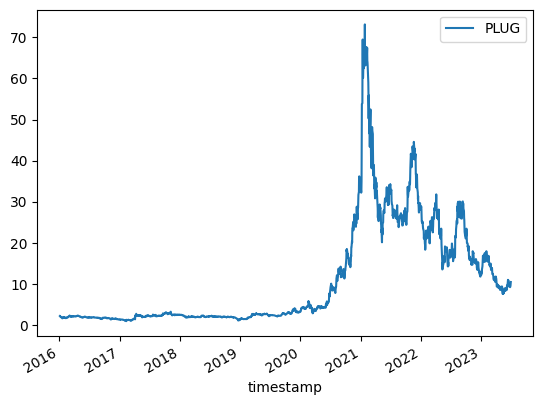

In [2]:

data.plot.line(y="close", use_index=True, label=SYMBOL)

In [3]:
split_prc = 0.8
train_data = data.iloc[:int(len(data)*split_prc)]
test_data =  data.iloc[int(len(data)*split_prc):]
print(len(data), len(train_data), len(test_data))
assert len(data) == len(train_data) + len(test_data)

1886 1508 378


## Training model

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

model = LinearRegression()

features = ['open', 'high', 'low', 'volume', 'trade_count', 'vwap']
target = "close"
X = train_data[features].values
y = train_data[target].values

model.fit(X, y)

X_test = test_data[features].values
y_test = test_data[target].values

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0762020186725906


## Setting up stratergy 

In [5]:
import numpy as np
from typing import List
from pandas import DataFrame

from cira.strategy import Strategy


class MyStrat(Strategy):
    def __init__(self, model=LinearRegression, risk = 0.02) -> None:
        super().__init__(name="MyStrat")
        self.model = model
        self.risk = risk
        self.sizeings = {"position_size":[]}

    def iterate(self, feature_data: DataFrame, prices: DataFrame, portfolio: np.ndarray, cash:float) -> np.ndarray:
        features = ['open', 'high', 'low', 'volume', 'trade_count', 'vwap']
        feature_data = feature_data[features]
        pred = self.model.predict(feature_data.values)
        sizeing = self.size(prices["close"].values[-1], pred[-1], cash, portfolio[-1])
        self.sizeings["position_size"].append(sizeing)
        return np.array([sizeing])

    def size(self, entry_price, predicted_price, cash, current_holding):
        return float(((predicted_price - entry_price)*(cash * (current_holding + 1 ) * self.risk )) / entry_price)

    
   

## Backtesting 

<Axes: xlabel='timestamp'>

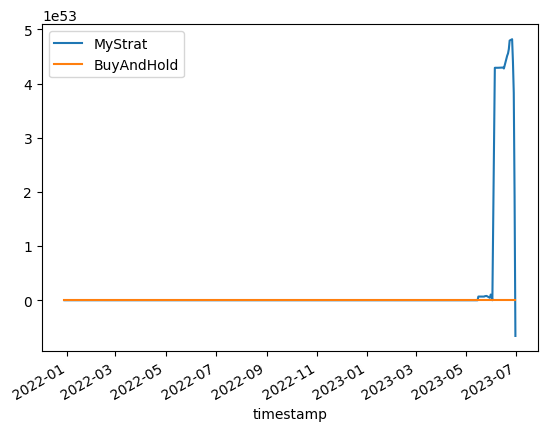

In [6]:
from cira.strategy import back_test_against_buy_and_hold as back_test

strat = MyStrat(model, risk=0.05)
prices_df = my_dataframe = pd.DataFrame(test_data[target], columns=['close'])
back_test(strat, test_data[features], prices_df, 10_000, allow_short_position=True).plot()

<Axes: >

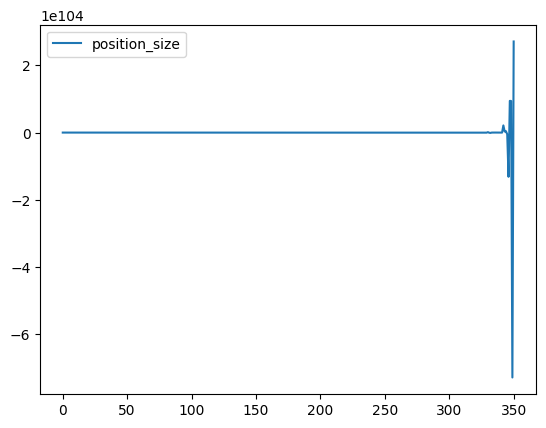

In [7]:
pd.DataFrame(strat.sizeings).plot()

In [8]:

strats = [cira.strategy.DollarCostAveraging(i) for i in range(-3, 4,1)]

prices_df = my_dataframe = pd.DataFrame(test_data[target], columns=['close'])
cira.strategy.multi_strategy_backtest(strats, test_data[features], prices_df, 10_000, allow_short_position=True).plot()

OverflowError: Python int too large to convert to C long

<Axes: xlabel='timestamp'>

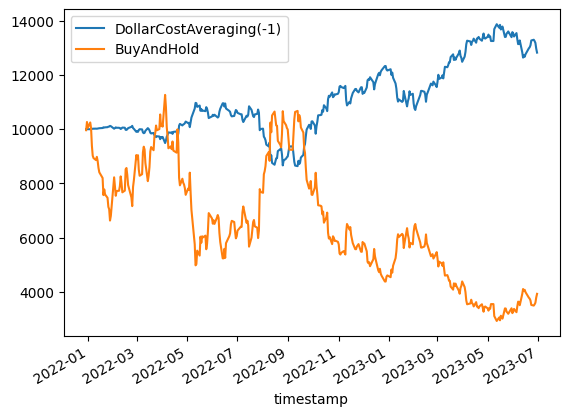

In [ ]:
strat = cira.strategy.DollarCostAveraging(amount=-1) 
prices_df = my_dataframe = pd.DataFrame(test_data[target], columns=['close'])
back_test(strat, test_data[features], prices_df, 10_000, allow_short_position=True).plot()

<Axes: >

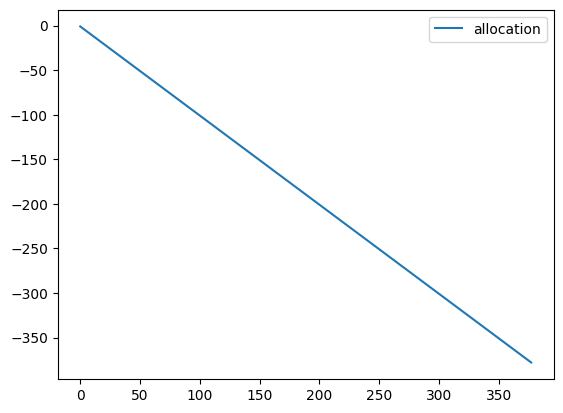

In [ ]:
pd.DataFrame({"allocation":np.array(strat.allocation).flatten().cumsum()}).plot()